# CycleGAN

## Set up the input pipeline

Install the [tensorflow_examples](https://github.com/tensorflow/examples) package that enables importing of the generator and the discriminator.

In [1]:
# !pip install -q git+https://github.com/tensorflow/examples.git

In [1]:
import tensorflow as tf
tf.__version__

'2.0.0'

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.experimental.AUTOTUNE
RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)

## Important: Sets up TF to not run out of GPU memory

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction=0.5
session = InteractiveSession(config=config)

## Input Pipeline

This tutorial trains a model to translate from images of horses, to images of zebras. You can find this dataset and similar ones [here](https://www.tensorflow.org/datasets/datasets#cycle_gan). 

As mentioned in the [paper](https://arxiv.org/abs/1703.10593), apply random jittering and mirroring to the training dataset. These are some of the image augmentation techniques that avoids overfitting.

This is similar to what was done in [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#load_the_dataset)

* In random jittering, the image is resized to `286 x 286` and then randomly cropped to `256 x 256`.
* In random mirroring, the image is randomly flipped horizontally i.e left to right.

In [4]:
# dataset, metadata = tfds.load('cycle_gan/horse2zebra',
#                               with_info=True, as_supervised=True)

# train_horses, train_zebras = dataset['trainA'], dataset['trainB']
# test_horses, test_zebras = dataset['testA'], dataset['testB']

In [5]:
PATH = "./input/cityscapes_cyclegan/"


def load_pair(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

In [6]:
def load_single(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    return image

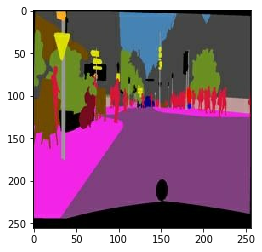

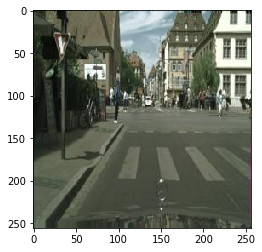

In [7]:
inp, re = load_pair(PATH+'train/2222.jpg')

# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [8]:
BUFFER_SIZE = 100
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [9]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [10]:
def preprocess_image_test(image, label=None):
  image = normalize(image)
  return image

In [11]:
def load_image_test(image_path):
    image = load_single(image_path)
    return preprocess_image_test(image)

In [12]:
def load_pair(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)
  
  input_image = tf.image.resize(input_image, [IMG_HEIGHT, IMG_WIDTH],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [IMG_HEIGHT, IMG_WIDTH],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

def load_pair_train(image_file):
  input_image, real_image = load_pair(image_file)
  return preprocess_image_train(input_image), preprocess_image_train(real_image)

def load_pair_test(image_file):
  input_image, real_image = load_pair(image_file)
  return preprocess_image_test(input_image), preprocess_image_test(real_image)

In [13]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [30]:
def generate_image_pairs(model, test_input, tar, fname=None):
  # the training=True is intentional here since
  # we want the batch statistics while running the model
  # on the test dataset. If we use training=False, we will get
  # the accumulated statistics learned from the training dataset
  # (which we don't want)
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
    
  if fname:
    plt.savefig('./output/{}.png'.format(fname), bbox_inches='tight')
  else:
    plt.show()

## Acquiring Labelled Data

In [42]:
tf.random.set_seed(RANDOM_SEED)

test_dataset = tf.data.Dataset.list_files(PATH+'test/*.jpg')
test_dataset = test_dataset.map(load_pair_test)
test_dataset = test_dataset.batch(1)

display_list = [] 

for inp,tar in test_dataset.take(3):
    display_list.append((inp,tar))

## Import and reuse the Pix2Pix models

In [16]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
# generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

# # Using conditional discrminators
# discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=True)
# discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=True)

## Getting 3 fixed samples

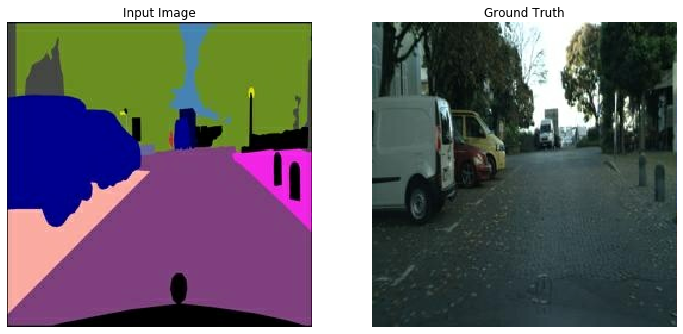

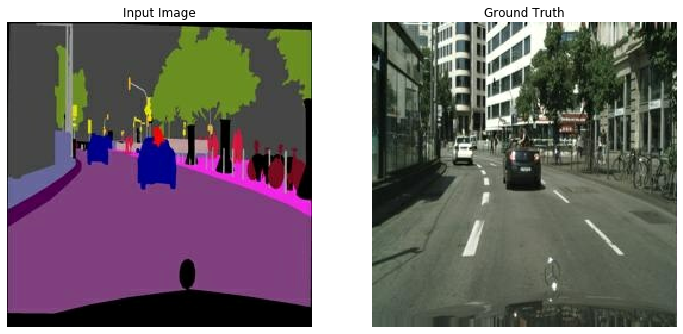

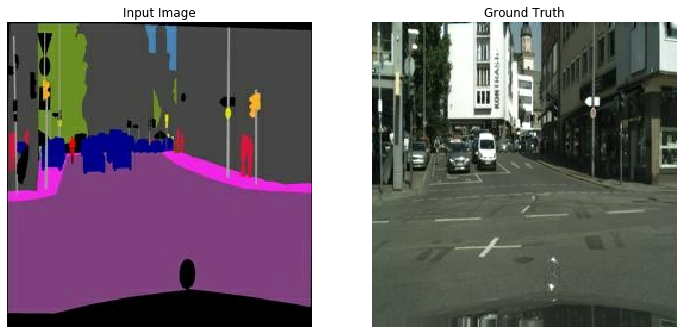

In [43]:

title = ['Input Image', 'Ground Truth']

for pairs in display_list:
    plt.figure(figsize=(12, 12))
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(pairs[i][0] * 0.5 + 0.5)
        plt.axis('off')

## Checkpoints

In [44]:
PARENTDIR = "/Volumes/SmaugDisk"

In [45]:
checkpoint_path = PARENTDIR+"/checkpoints_cyclegan/unsup_train/"

unsupervised_ckpt = tf.train.Checkpoint(generator_g=generator_g)

unsupervised_ckpt_manager = tf.train.CheckpointManager(unsupervised_ckpt, checkpoint_path, max_to_keep=None)

# if a checkpoint exists, restore the latest checkpoint.
ckpt_number = -1 # This should go in reverse (-ve)
if unsupervised_ckpt_manager.latest_checkpoint:
    print("Found:", unsupervised_ckpt_manager.checkpoints[ckpt_number])
    unsupervised_ckpt.restore(unsupervised_ckpt_manager.checkpoints[ckpt_number])
    print ('Checkpoint {} restored!'.format(len(unsupervised_ckpt_manager.checkpoints)+ckpt_number+1))

In [46]:
unsupervised_ckpt_manager.latest_checkpoint

In [51]:
checkpoint_dir = './checkpoints_cyclegan/super_train'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator=generator_g)

sup_ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=None)
# if a checkpoint exists, restore the latest checkpoint.
if sup_ckpt_manager.latest_checkpoint:
  checkpoint.restore(sup_ckpt_manager.latest_checkpoint).expect_partial()
  print ('Checkpoint {} restored!'.format(len(sup_ckpt_manager.checkpoints)+1))

W1212 12:18:41.118990 4443262400 util.py:144] Unresolved object in checkpoint: (root).discriminator
W1212 12:18:41.120160 4443262400 util.py:144] Unresolved object in checkpoint: (root).discriminator_optimizer
W1212 12:18:41.121487 4443262400 util.py:144] Unresolved object in checkpoint: (root).generator_optimizer
W1212 12:18:41.122418 4443262400 util.py:144] Unresolved object in checkpoint: (root).discriminator.layer-0
W1212 12:18:41.123167 4443262400 util.py:144] Unresolved object in checkpoint: (root).discriminator.layer-1
W1212 12:18:41.124077 4443262400 util.py:144] Unresolved object in checkpoint: (root).discriminator.layer-2
W1212 12:18:41.124795 4443262400 util.py:144] Unresolved object in checkpoint: (root).discriminator.layer_with_weights-0
W1212 12:18:41.125786 4443262400 util.py:144] Unresolved object in checkpoint: (root).discriminator.layer_with_weights-1
W1212 12:18:41.126544 4443262400 util.py:144] Unresolved object in checkpoint: (root).discriminator.layer_with_weights

Checkpoint 4 restored!


## Generate using test dataset

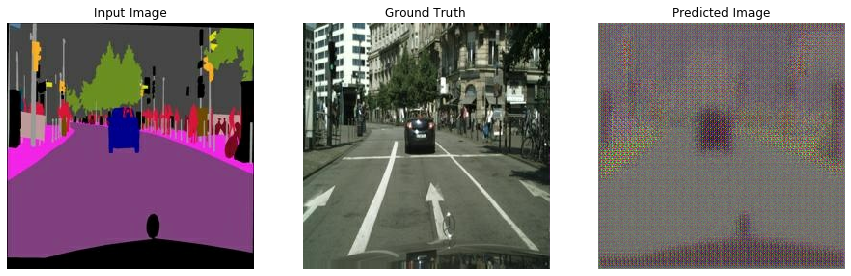

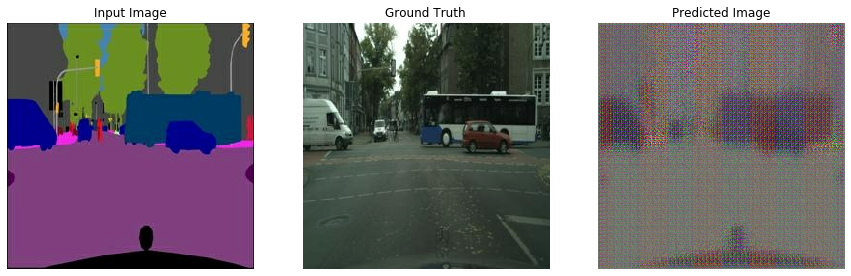

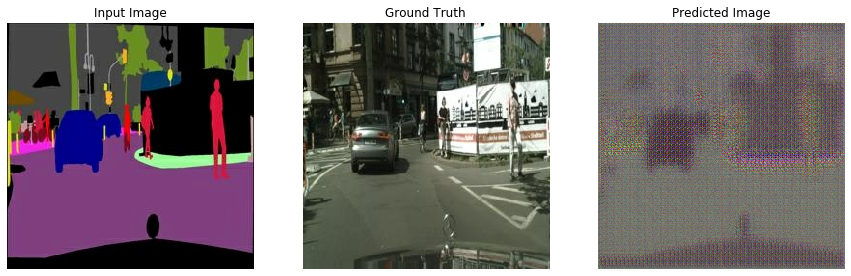

CPU times: user 4.7 s, sys: 649 ms, total: 5.35 s
Wall time: 1.49 s


In [24]:
%%time
# Run the trained model on the test dataset
for mask,city in testers:
  generate_image_pairs(generator_g, mask,city)

## Reconstructing from checkpoints

Checkpoint: 0
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
Checkpoint: 1
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
Checkpoint: 2
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)


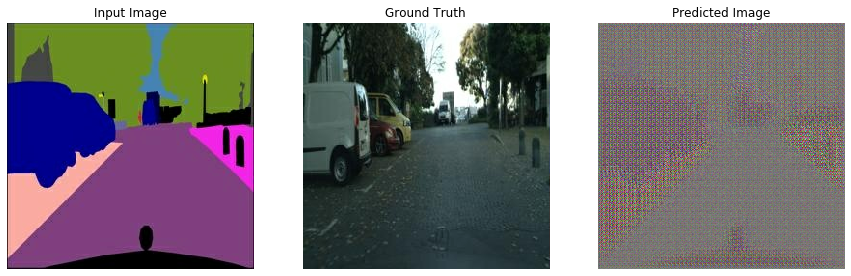

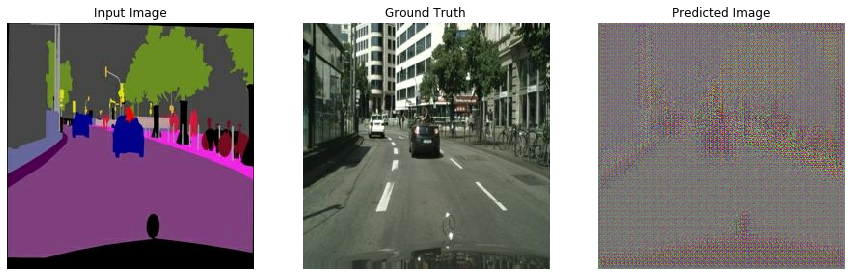

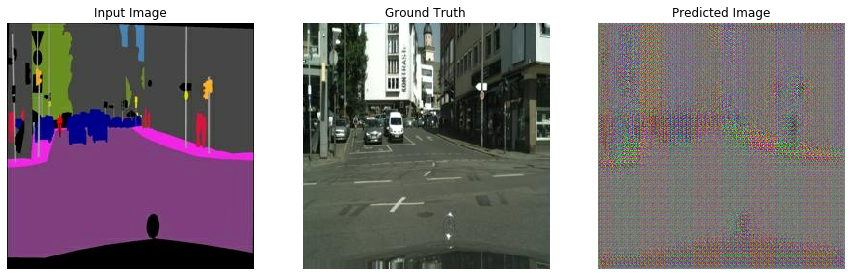

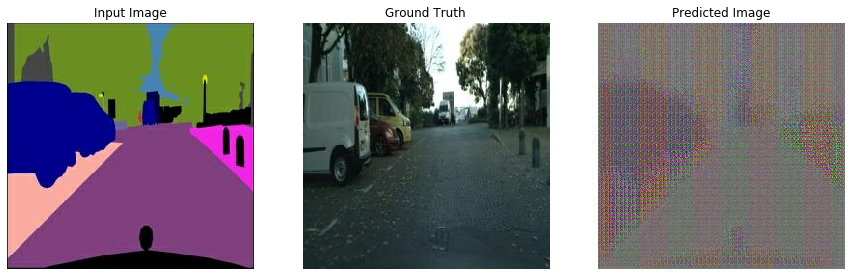

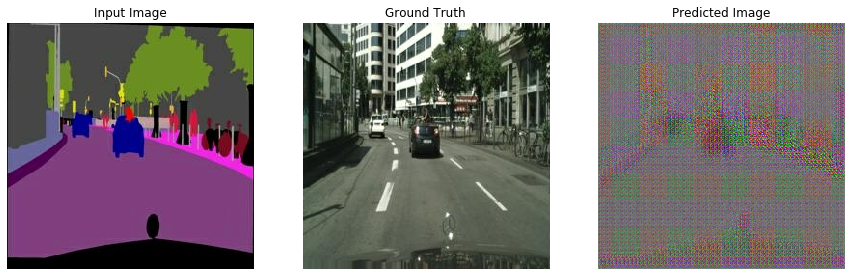

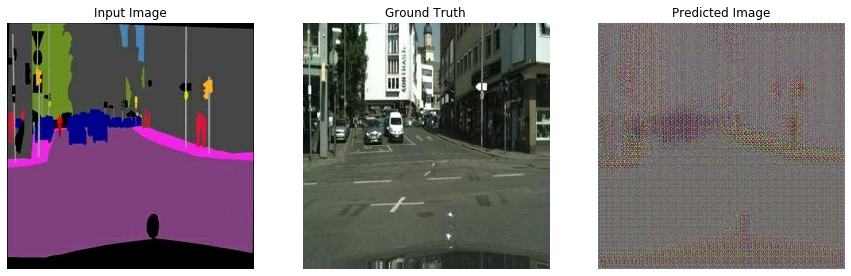

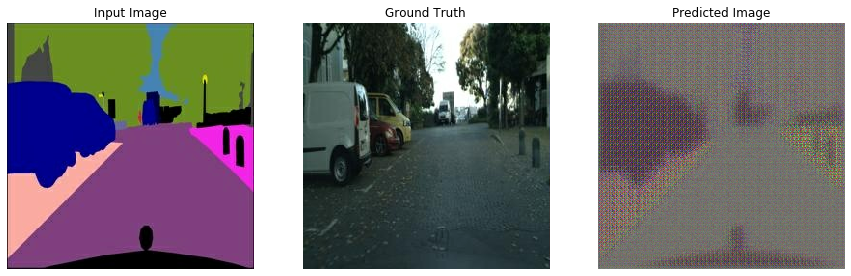

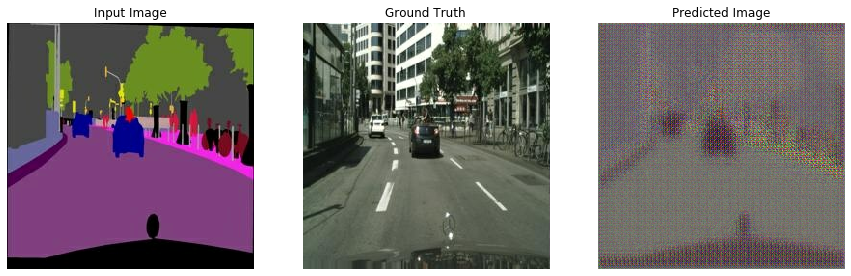

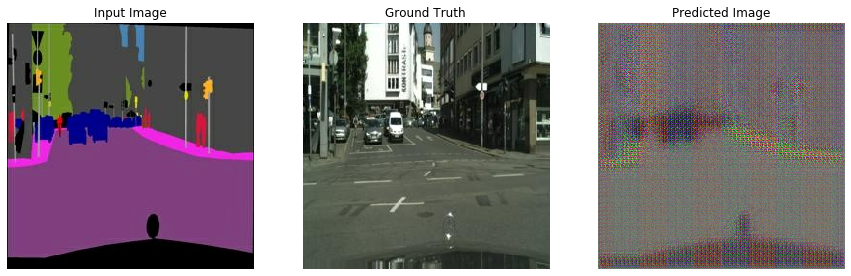

In [53]:
for ckpt_num, ckpt_ in enumerate(sup_ckpt_manager.checkpoints):
    print("Checkpoint:", ckpt_num)
    checkpoint.restore(ckpt_)
    tnum=0
    for mask,city in display_list:
#         print(mask.shape)
        generate_image_pairs(generator_g, mask,city, fname="pretrain_1/t{}/g_c{}".format(tnum,ckpt_num))
        tnum+=1

In [3]:
# for ckpt_num, ckpt_ in enumerate(unsupervised_ckpt_manager.checkpoints):
#     print("Checkpoint:", ckpt_num)
#     unsupervised_ckpt.restore(ckpt_)
#     generate_image_pairs(generator_f, example_target, example_input, fname="1by1/f_epoch_{:04d}".format(ckpt_num))
# #     plt.savefig('./output/1by1/epoch_{:04d}.png'.format(ckpt_num), bbox_inches='tight')